In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
x = np.fromfile('/home/daniel/aoa_aprs_2019-04-28T09:48:40.565206.2xc64', dtype = 'complex64').reshape((-1,2))

In [3]:
fs = 25000

In [4]:
x.shape

(95745792, 2)

In [5]:
average = fs//10
corr = x[:,0] * np.conj(x[:,1])
corr = np.sum(corr[:corr.size//average*average].reshape((-1,average)), axis = 1)
t_corr = np.datetime64('2019-04-28T09:48:40.565206') + np.arange(corr.size)/(fs//average) * 1e9 * np.timedelta64(1,'ns')

In [6]:
def spectrum_plot(ax, x):
    f, t, Sxx = scipy.signal.spectrogram(x, fs, return_onesided=False)
    f = np.fft.fftshift(f)
    ax.imshow(np.fft.fftshift(np.log10(Sxx), axes=0), extent = [t[0],t[-1],f[-1],f[0]], aspect='auto', cmap='viridis', vmax = -7, vmin = -13)

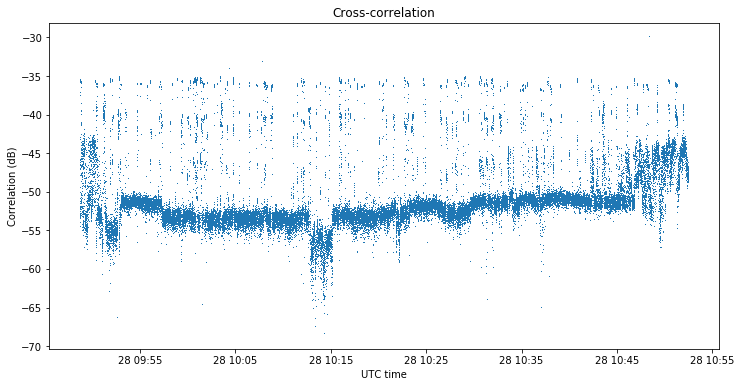

In [7]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_corr, 10*np.log10(np.abs(corr)), ',')
plt.title('Cross-correlation')
plt.xlabel('UTC time')
plt.ylabel('Correlation (dB)');

In [8]:
accepted = 10*np.log10(np.abs(corr)) > -41

In [9]:
baseline_orientation = np.deg2rad(35)
ed4zae_azimuth = np.deg2rad(237)
ed4zae_relative = ed4zae_azimuth - baseline_orientation
ed4zae_expected_phase = -np.sin(ed4zae_relative)*np.pi
ed4zae_phase = 2

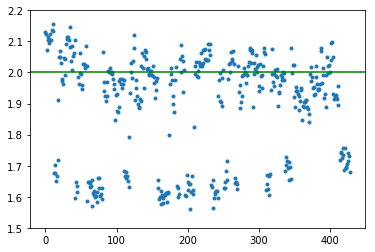

In [10]:
plt.plot(np.angle(corr[10*np.log10(np.abs(corr)) > -36]), '.')
plt.axhline(y = ed4zae_phase, color = 'green')
plt.ylim([1.5,2.2]);

In [11]:
phase_corr = ed4zae_expected_phase - ed4zae_phase
#phase_corr = 0
phase = np.angle(corr * np.exp(1j*phase_corr))
azimuth = np.rad2deg(-np.arcsin(phase/np.pi))

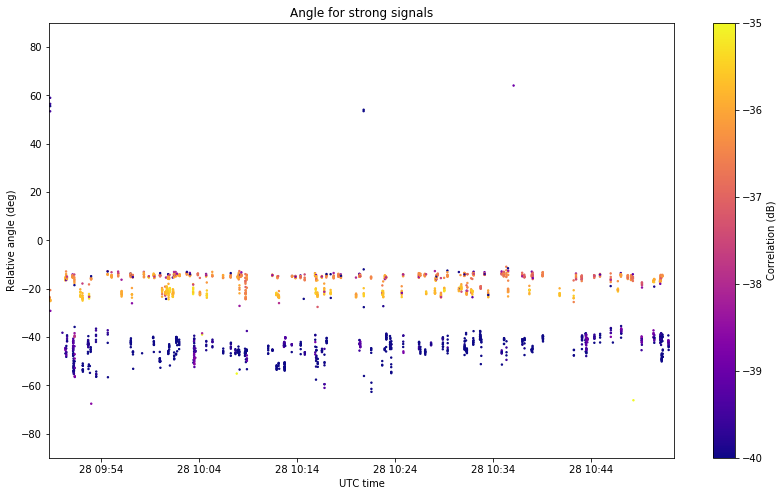

In [12]:
plt.figure(figsize = (14,8), facecolor = 'w')
plt.scatter(t_corr[accepted], azimuth[accepted], s = 2, c = 10*np.log10(np.abs(corr[accepted])), cmap = 'plasma', vmax = -35, vmin = -40)
plt.xlim([t_corr[0], t_corr[-1]])
plt.ylim([-90,90])
cb = plt.colorbar()
cb.set_label('Correlation (dB)', rotation = 90)
plt.xlabel('UTC time')
plt.ylabel('Relative angle (deg)')
plt.title('Angle for strong signals');

In [13]:
n_secs = 30
for j,start in enumerate(range(0, x.shape[0], fs * n_secs)):
    fig, ax1 = plt.subplots(figsize = (15,4))
    spectrum_plot(ax1, x[start:start+fs*n_secs,0])
    ax2 = ax1.twinx()
    az = np.rad2deg(-np.arcsin(phase[start//average:(start+fs*n_secs)//average]/np.pi))
    ax2.plot(np.arange(az.size)/(fs//average), az, '.', color = 'red')
    ax2.set_ylim([-90, 90])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Freq (Hz)')
    ax2.set_ylabel('Relative angle (deg)', color = 'red')
    fig.savefig(f'/tmp/plot_{j:03d}')
    plt.close()